In [1]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool

def get_merge_count(item, tokens):
    rank = {token:i for i,token in enumerate(tokens)}
#     word2bytes = {word:[bytes([b]) for b in word.encode("utf-8")] for word in counts}
#     word2part = {w:np.zeros(len(b))-1 for w,b in word2bytes.items()}
#     word2dup = {w:np.zeros(len(b)) for w,b in word2bytes.items()}
    w, count = item
    b = [bytes([byte]) for byte in w.encode("utf-8")]
    arr = np.zeros(len(b))-1
    dup = np.zeros(len(b))
    
    total_scores = []
    add_merges = []
    partitions = []
    total_counter = 0
    
    for _id, token in enumerate(tokens):
        j = len(token)
        counter = 0
        i = 0
        
        if len(token) == 1 or len(arr) < j: 
            add_merges.append(counter)
            total_scores.append(total_counter)
            partitions.append(partitions[-1] if len(partitions)>0 else len(w)*count)
            continue
            
        if len(arr) == j and tuple(b) == token:
            nones = 0
            uniqs = set()
            for k in range(len(arr)):
                if arr[k] == -1:
                    nones += 1
                else:
                    uniqs.add(arr[k])
            arr[:] = rank[token]
            counter += count * (nones + len(uniqs) - 1)
        else:
            dup_counter = 0
            while i <= len(arr)-j:
                if b[i] != token[0]: 
                    i+=1
                    continue
                elif b[i+j-1] != token[-1]: 
                    i+=1
                    continue
                elif tuple(b[i:i+j]) != token: 
                    i+=1
                    continue
                # word part match token
                # check arr
                if i > 0:
                    if arr[i-1] != -1 and arr[i-1]==arr[i] and dup[i-1]==dup[i]:
                        i+=1
                        continue
                if i+j < len(arr):
                    if arr[i+j] != -1 and arr[i+j-1]==arr[i+j] and dup[i+j-1]==dup[i+j]:
                        i+=1
                        continue

                nones = 0
                uniqs = set()
                for k in range(i,i+j):
                    if arr[k] == -1:
                        nones += 1
                    else:
                        uniqs.add(arr[k])        
                arr[i:i+j] = rank[token]
                dup[i:i+j] = dup_counter
                counter += count * (nones + len(uniqs) - 1)
                dup_counter += 1
                i += len(token)
                
        
        parts = 1
        for i in range(len(arr)-1):
            if arr[i] == -1 or arr[i] != arr[i+1] or dup[i] != dup[i+1]:
                parts+=1
                
        total_counter += counter
        total_scores.append(total_counter)
        add_merges.append(counter)
        partitions.append(parts * count)        
        
    return w, add_merges, total_scores, partitions,# arr, dup

def get_merge_count_main(tokens, count):
    sum_qty_words = sum(count.values())
    with Pool(30) as p:
        outputs = p.map_async(partial(get_merge_count, tokens=tokens), tqdm(count.items()))
#     return outputs
    add_merges = np.array([o[1] for o in outputs]).sum(axis=0)
    total_scores = np.array([o[2] for o in outputs]).sum(axis=0)
    total_partitions = np.array([o[3] for o in outputs]).sum(axis=0)/sum_qty_words
#     word2part = {o[0]:o[-2] for o in outputs}
#     word2dup = {o[0]:o[-1] for o in outputs}
    return add_merges, total_scores, total_partitions#, word2part, word2dup

def sentencepiece_bpe_shift(add_merges, total_scores, total_partitions, alpha, start, stop):
    neg_add_merges = add_merges[start:stop]
    neg_total_scores = total_scores[start:stop]
    neg_total_partitions = total_partitions[start:stop]
    pos_add_merges = np.hstack((np.sum(add_merges[:alpha]), add_merges[alpha:]))
    pos_total_scores = np.hstack((np.sum(total_scores[:alpha]), total_scores[alpha:]))
    pos_total_partitions = np.hstack((np.sum(total_partitions[:alpha]), total_partitions[alpha:]))

def calc_token_per_word(items):
    w, part, dup = items
    partitions = 1
    for i in range(len(part)-1):
        if part[i] == -1 or part[i] != part[i+1] or dup[i] != dup[i+1]:
            partitions+=1
    return w, partitions

def calc_token_per_word_main(word2part, word2dup, counts):
    with Pool(30) as p:
        outputs = p.map(calc_token_per_word,
                        tqdm([(w, k, word2dup[w]) for w,k in word2part.items()]))
    outputs = {w:k for w,k in outputs}
    total_parts = sum([outputs[w]*counts[w] for w in counts])
    total_words = sum(list(counts.values()))
    return total_parts/total_words

In [10]:
# using huggingface implt of bytelevel BPE
bpe_tokens = {}
bpe_merges = {}
bpe_scores = {}
bpe_word2part = {}
bpe_word2dup = {}
bpe_word2partscore = {}
for domain in ['un','arxiv']:
    start = 0
    stop = 5000
    counts = pickle.load(open(f"python_inputs/{domain}_counts.pkl",'rb'))
    bpe_db = pickle.load(open(f"python_outputs/hf_bpe/{domain}_tokens.pkl",'rb'))
    bpe_tokens[domain] = []
    for p in bpe_db:
        token = [bytes([b]) for b in p.encode('utf-8')]
        bpe_tokens[domain].append(tuple(token))
    bpe_merges[domain], bpe_scores[domain], bpe_word2partscore[domain], \
    bpe_word2part[domain], bpe_word2dup[domain] = get_merge_count_main(bpe_tokens[domain][start:stop], counts)

100%|██████████| 881233/881233 [07:37<00:00, 1926.58it/s]  


In [11]:
for domain in ['un', 'arxiv']:
    pickle.dump(
        {'merges':bpe_merges[domain],
         'total_scores': bpe_scores[domain],
         'tokens_per_word': bpe_word2partscore[domain],
         'word2part':bpe_word2part[domain],
         'word2dup':bpe_word2dup[domain]}, 
        open(f"python_outputs/hf_bpe/{domain}_bpe_results.pkl",'wb'))

In [ ]:
#load previously calculated results
bpe_tokens = {}
bpe_merges = {}
bpe_scores = {}
bpe_word2partscore = {}
for domain in ['un', 'arxiv']:
    bpe_tokens[domain] = list(pickle.load(open(f"python_outputs/{domain}_initial_cache.pkl",'rb'))['tokens'])
    load = pickle.load(open(f"python_outputs/hf_bpe/{domain}_bpe_results.pkl",'rb'))
    bpe_merges[domain], bpe_scores[domain], bpe_word2partscore[domain] = load['merges'], load['total_scores'], load['tokens_per_word']

In [211]:
# using previous impl of BPE

bpe_tokens = {}
bpe_merges = {}
bpe_scores = {}
bpe_word2part = {}
bpe_word2dup = {}
bpe_word2partscore = {}
for domain in ['un','arxiv']:
    start = 0
    stop = 5000
    counts = pickle.load(open(f"python_inputs/{domain}_counts.pkl",'rb'))
    bpe_db = pickle.load(open(f"python_outputs/{domain}_bpe.pkl",'rb'))
    bpe_tokens[domain] = []
    for p1, p2 in bpe_db['rules']:
        token = []
        token.extend([bytes([b]) for b in p1])
        token.extend([bytes([b]) for b in p2])
        bpe_tokens[domain].append(tuple(token))
    bpe_merges[domain], bpe_scores[domain], bpe_word2partscore[domain], \
    bpe_word2part[domain], bpe_word2dup[domain] = get_merge_count_main(bpe_tokens[domain][start:stop], counts)

100%|██████████| 881233/881233 [07:23<00:00, 1987.34it/s]   


In [ ]:
#load previously calculated results
bpe2_tokens = {}
bpe2_merges = {}
bpe2_scores = {}
bpe2_word2partscore = {}
for domain in ['un', 'arxiv']:
    bpe2_tokens[domain] = list(pickle.load(open(f"python_outputs/{domain}_initial_cache.pkl",'rb'))['tokens'])
    load = pickle.load(open(f"python_outputs/hf_bpe/{domain}_bpe_results.pkl",'rb'))
    bpe2_merges[domain], bpe2_scores[domain], bpe2_word2partscore[domain] = load['merges'], load['total_scores'], load['tokens_per_word']

In [ ]:
greed_tokens = {}
greed_merges = {}
greed_scores = {}
greed_word2part = {}
greed_word2dup = {}
greed_word2partscore={}
for domain in ['un','arxiv']:
    start = 0
    stop = 5000
    counts = pickle.load(open(f"python_inputs/{domain}_counts.pkl",'rb'))
    greed_tokens[domain] = list(pickle.load(open(f"python_outputs/{domain}_initial_cache.pkl",'rb'))['tokens'])
    greed_merges[domain], greed_scores[domain], greed_word2partscore[domain], \
    greed_word2part[domain], greed_word2dup[domain] = get_merge_count_main(greed_tokens[domain][start:stop], counts)

In [241]:
for domain in ['un', 'arxiv']:
    pickle.dump(
        {'merges':greed_merges[domain],
         'total_scores': greed_scores[domain],
         'tokens_per_word': greed_word2partscore[domain],
         'word2part':greed_word2part[domain],
         'word2dup':greed_word2dup[domain]}, 
        open(f"python_outputs/{domain}_greedy_results.pkl",'wb'))

In [9]:
#load previously calculated results
greed_tokens = {}
greed_merges = {}
greed_scores = {}
greed_word2partscore={}
for domain in ['un', 'arxiv']:
    greed_tokens[domain] = list(pickle.load(open(f"python_outputs/{domain}_initial_cache.pkl",'rb'))['tokens'])
    load = pickle.load(open(f"python_outputs/{domain}_greedy_results.pkl",'rb'))
    greed_merges[domain], greed_scores[domain], greed_word2partscore[domain] = load['merges'], load['total_scores'], load['tokens_per_word']

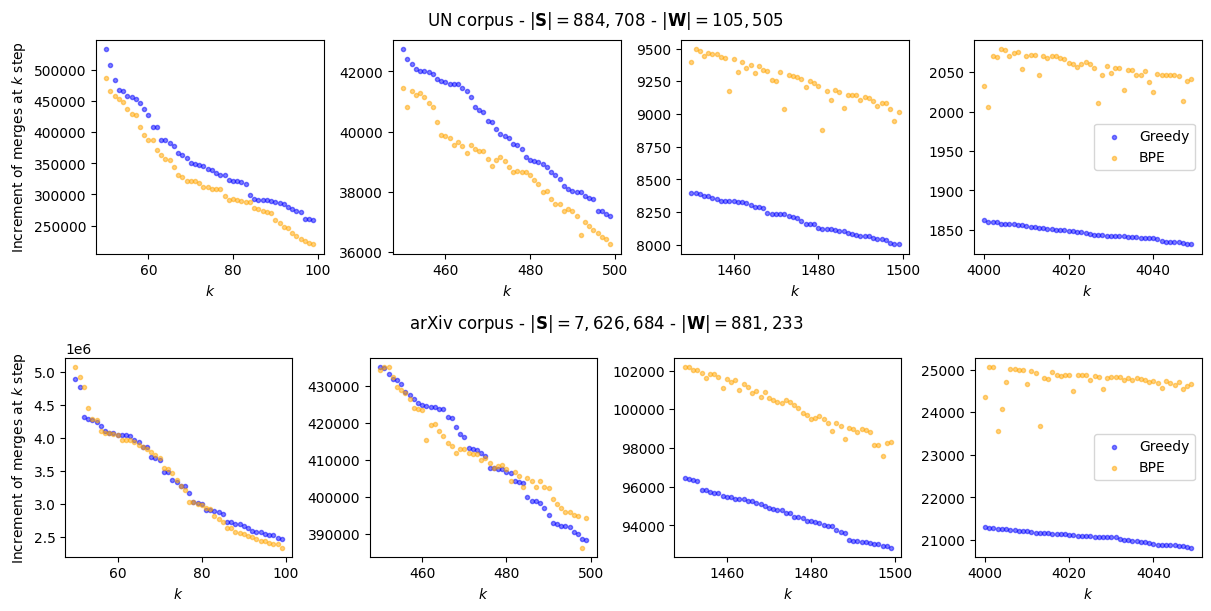

In [13]:
# New results using huggingface impl of bytelevel BPE

fig = plt.figure(constrained_layout=True, figsize=(12,6))
# fig.suptitle('Figure title')            # set global suptitle if desired
suptitles = [r'UN corpus - $|\mathbf{S}|=884,708$ - $|\mathbf{W}|=105,505$',
            r'arXiv corpus - $|\mathbf{S}|=7,626,684$ - $|\mathbf{W}|=881,233$']
subfigs = fig.subfigures(2, 1) 
for d, domain in enumerate(['un','arxiv']):
    
    axs = subfigs[d].subplots(1, 4)  
    for idx, scope in enumerate([(50,100), (450,500), (1450,1500), (4000,4050)]):
        i,j = scope
        axs[idx].scatter(range(len(greed_merges[domain]))[i:j], greed_merges[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].scatter(range(len(bpe_merges[domain]))[i:j], bpe_merges[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        axs[idx].set_xlabel("$k$")
    axs[-1].legend()
    axs[0].set_ylabel("Increment of merges at $k$ step")
    subfigs[d].suptitle(suptitles[d])

plt.show()

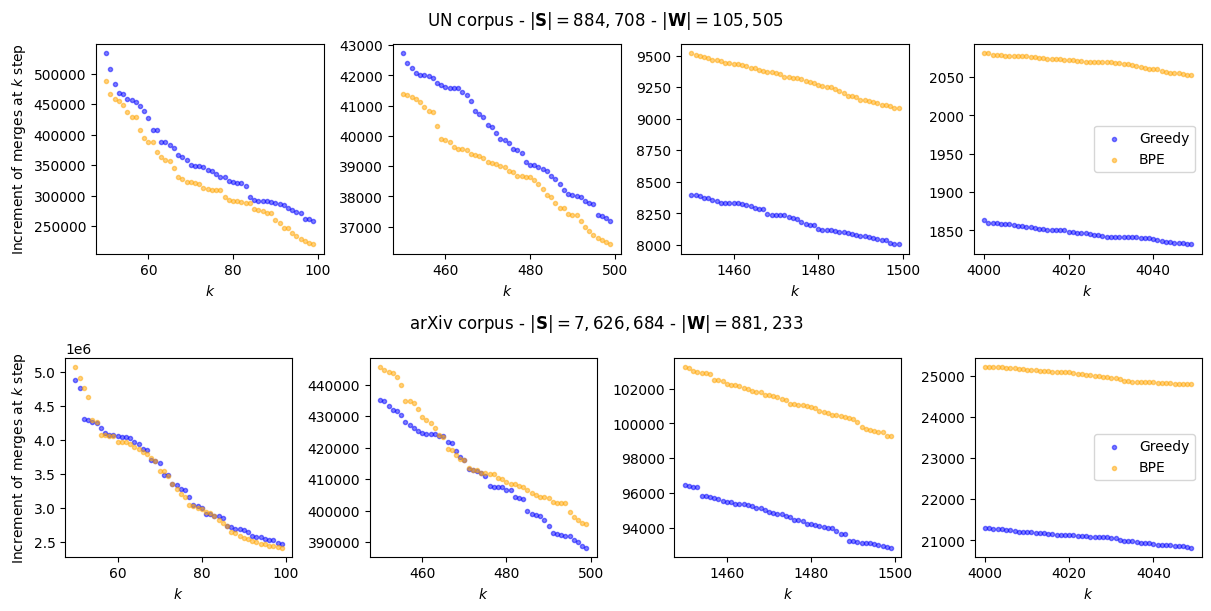

In [153]:
# Old results using previous impl of BPE

fig = plt.figure(constrained_layout=True, figsize=(12,6))
# fig.suptitle('Figure title')            # set global suptitle if desired
suptitles = [r'UN corpus - $|\mathbf{S}|=884,708$ - $|\mathbf{W}|=105,505$',
            r'arXiv corpus - $|\mathbf{S}|=7,626,684$ - $|\mathbf{W}|=881,233$']
subfigs = fig.subfigures(2, 1) 
for d, domain in enumerate(['un','arxiv']):
    
    axs = subfigs[d].subplots(1, 4)  
    for idx, scope in enumerate([(50,100), (450,500), (1450,1500), (4000,4050)]):
        i,j = scope
        axs[idx].scatter(range(len(greed_merges[domain]))[i:j], greed_merges[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].scatter(range(len(bpe_merges[domain]))[i:j], bpe_merges[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        axs[idx].set_xlabel("$k$")
    axs[-1].legend()
    axs[0].set_ylabel("Increment of merges at $k$ step")
    subfigs[d].suptitle(suptitles[d])

plt.show()

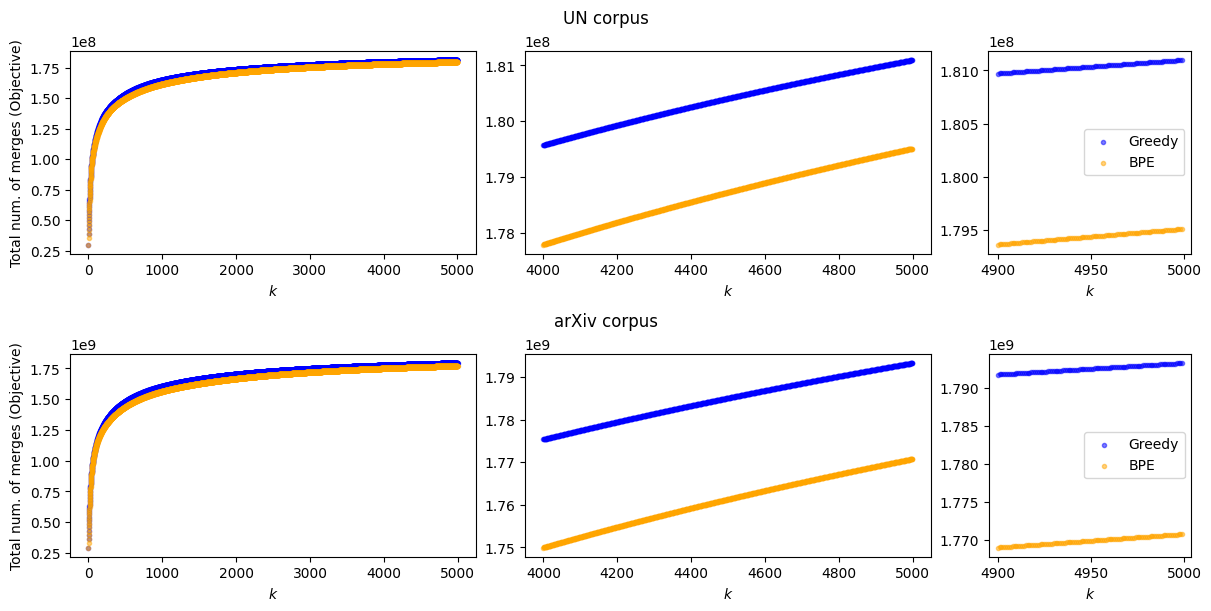

In [14]:
# New results using huggingface impl of BPE

fig = plt.figure(constrained_layout=True, figsize=(12,6))

suptitles = [f'UN corpus',
            f'arXiv corpus']
subfigs = fig.subfigures(2, 1) 
for d, domain in enumerate(['un','arxiv']):
    axs = subfigs[d].subplots(1, 3, width_ratios=[2, 2, 1])
    for idx, scope in enumerate([(0,5000), (4000,5000), (4900,5000)]):
        i,j = scope
        axs[idx].scatter(range(len(greed_scores[domain]))[i:j], greed_scores[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].scatter(range(len(bpe_scores[domain]))[i:j], bpe_scores[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        axs[idx].set_xlabel("$k$")
    axs[-1].legend()
    axs[0].set_ylabel("Total num. of merges (Objective)")
    subfigs[d].suptitle(suptitles[d])
plt.show()

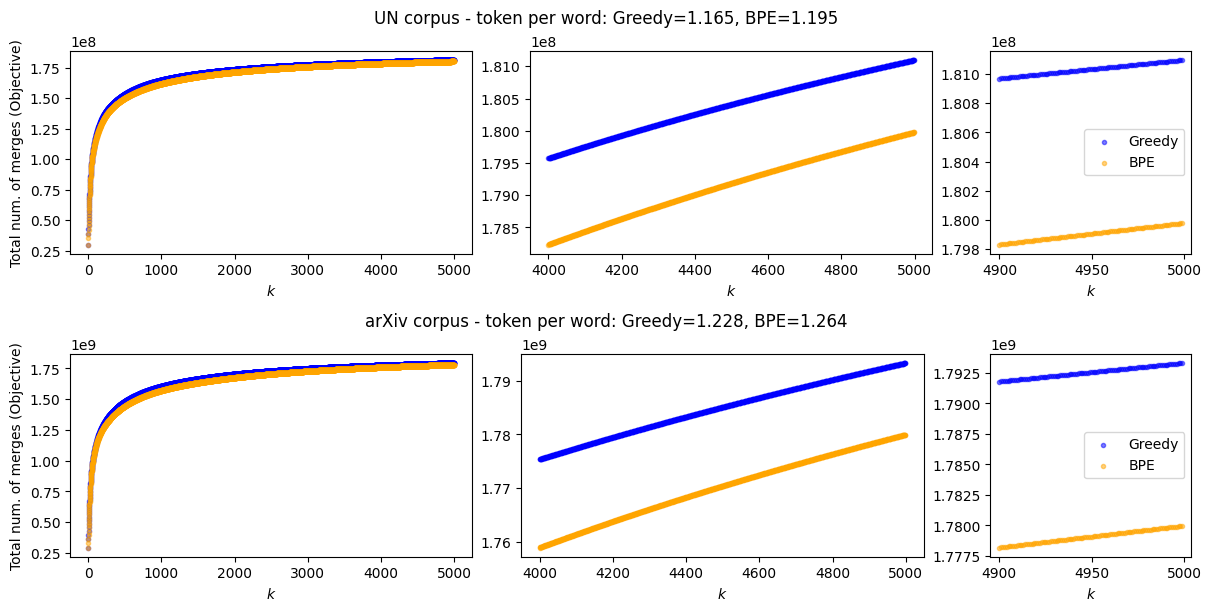

In [177]:
# Old results using previous impl of BPE

fig = plt.figure(constrained_layout=True, figsize=(12,6))

suptitles = [f'UN corpus',
            f'arXiv corpus']
subfigs = fig.subfigures(2, 1) 
for d, domain in enumerate(['un','arxiv']):
    axs = subfigs[d].subplots(1, 3, width_ratios=[2, 2, 1])
    for idx, scope in enumerate([(0,5000), (4000,5000), (4900,5000)]):
        i,j = scope
        axs[idx].scatter(range(len(greed_scores[domain]))[i:j], greed_scores[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].scatter(range(len(bpe_scores[domain]))[i:j], bpe_scores[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        axs[idx].set_xlabel("$k$")
    axs[-1].legend()
    axs[0].set_ylabel("Total num. of merges (Objective)")
    subfigs[d].suptitle(suptitles[d])
plt.show()

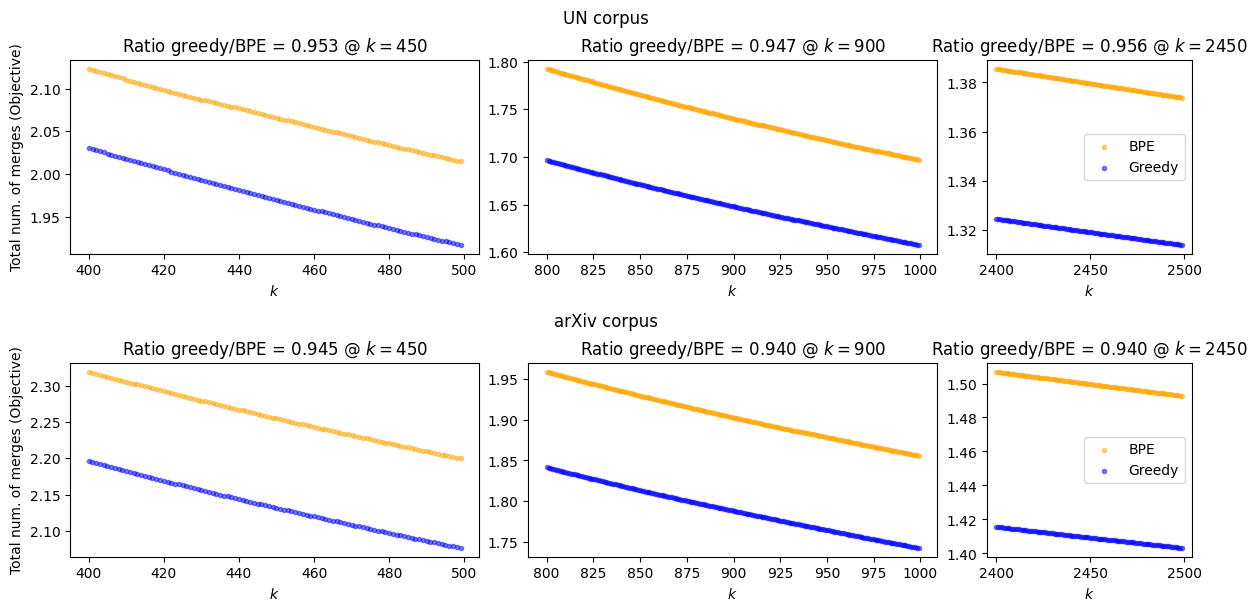

In [16]:
# New results using huggingface impl of BPE

fig = plt.figure(constrained_layout=True, figsize=(12,6))

suptitles = [f'UN corpus',
            f'arXiv corpus']
subfigs = fig.subfigures(2, 1) 
for d, domain in enumerate(['un','arxiv']):
    axs = subfigs[d].subplots(1, 3, width_ratios=[2, 2, 1])
    for idx, scope in enumerate([(400,500), (800,1000), (2400,2500)]):
        i,j = scope
        axs[idx].scatter(range(len(bpe_word2partscore[domain]))[i:j], bpe_word2partscore[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        axs[idx].scatter(range(len(greed_word2partscore[domain]))[i:j], greed_word2partscore[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].set_xlabel("$k$")
        inspect = int((i+j)/2)
        if inspect < len(greed_word2partscore[domain]):
            axs[idx].set_title(f"Ratio greedy/BPE = \
{greed_word2partscore[domain][inspect]/bpe_word2partscore[domain][inspect]:.3f} \
@ $k={inspect}$")
    axs[-1].legend()
    axs[0].set_ylabel("Total num. of merges (Objective)")
    subfigs[d].suptitle(suptitles[d])
plt.show()

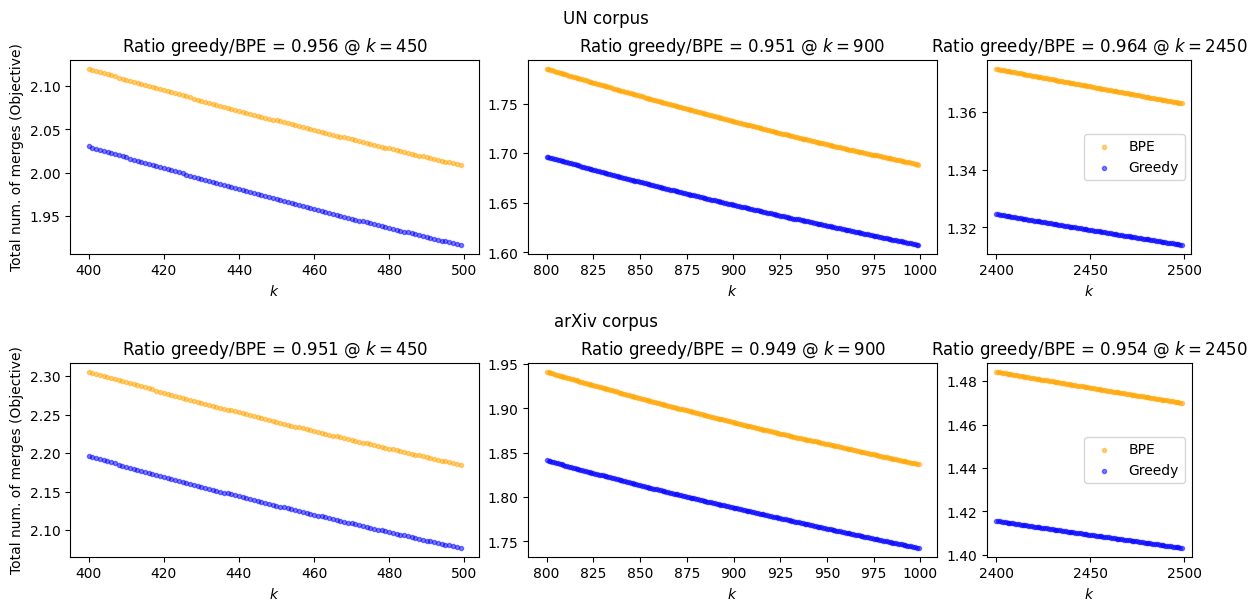

In [242]:
# Old results using previous impl of BPE

fig = plt.figure(constrained_layout=True, figsize=(12,6))

suptitles = [f'UN corpus',
            f'arXiv corpus']
subfigs = fig.subfigures(2, 1) 
for d, domain in enumerate(['un','arxiv']):
    axs = subfigs[d].subplots(1, 3, width_ratios=[2, 2, 1])
    for idx, scope in enumerate([(400,500), (800,1000), (2400,2500)]):
        i,j = scope
        axs[idx].scatter(range(len(bpe_word2partscore[domain]))[i:j], bpe_word2partscore[domain][i:j], color='orange', marker='.', alpha=.5, label='BPE')
        axs[idx].scatter(range(len(greed_word2partscore[domain]))[i:j], greed_word2partscore[domain][i:j], color='blue', marker='.', alpha=.5, label='Greedy')
        axs[idx].set_xlabel("$k$")
        inspect = int((i+j)/2)
        if inspect < len(greed_word2partscore[domain]):
            axs[idx].set_title(f"Ratio greedy/BPE = \
{greed_word2partscore[domain][inspect]/bpe_word2partscore[domain][inspect]:.3f} \
@ $k={inspect}$")
    axs[-1].legend()
    axs[0].set_ylabel("Total num. of merges (Objective)")
    subfigs[d].suptitle(suptitles[d])
plt.show()

In [17]:
def bold(s):
    return '\033[1m' + s + '\033[0m'

def ul(s):
    return '\033[4m' + s + '\033[0m'

def b_cond(s , target_ratio):
    if target_ratio == 15 or target_ratio == 25:
        return bold(s)
    return s

In [18]:
target_ratios = [13+(x*2) for x in range(8)]
greed_ratio2k = {}
bpe_ratio2k = {}
greed_k2ratio = {}
bpe_k2ratio = {}

for domain in ['un', 'arxiv']:
    greed_ratio2k[domain] = {}
    greed_k2ratio[domain] = {}
    bpe_ratio2k[domain] = {}
    bpe_k2ratio[domain] = {}
    for target_ratio in target_ratios:
        tr = target_ratio/10
        best_diff = 9999
        for k, token_per_word in enumerate(greed_word2partscore[domain]):
            diff = abs(token_per_word-tr)
            if diff < best_diff:
                best_diff = diff
                greed_ratio2k[domain][target_ratio] = k
                greed_k2ratio[domain][k] = token_per_word
                
                bpe_k2ratio[domain][k] = bpe_word2partscore[domain][k]
                bpe_ratio2k[domain][bpe_word2partscore[domain][k]] = k
        
        best_diff = 9999
        for k, token_per_word in enumerate(bpe_word2partscore[domain]):
            diff = abs(token_per_word-tr)
            if diff < best_diff:
                best_diff = diff
                bpe_ratio2k[domain][target_ratio] = k
                bpe_k2ratio[domain][k] = token_per_word
                
                greed_k2ratio[domain][k] = greed_word2partscore[domain][k]
                greed_ratio2k[domain][greed_word2partscore[domain][k]] = k


# New results using previous impl of BPE

for domain in ['un', 'arxiv']:
    print(ul(bold(domain)))
    print("token/w tar\t", "\t".join([ul(b_cond(f"{tr/10:.1f}",tr)) for tr in target_ratios]))
    print("Greedy $k$\t", "\t".join([b_cond(f"{greed_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("BPE t/w   \t", "\t".join([b_cond(f"{bpe_k2ratio[domain][greed_ratio2k[domain][tr]]:.3f}",tr) for tr in target_ratios]))
    
    print("Greedy/BPE\t", "\t".join([b_cond(f"{tr/10/bpe_k2ratio[domain][greed_ratio2k[domain][tr]]:.3f}",tr) for tr in target_ratios]))
    print("BPE tar@k \t", "\t".join([b_cond(f"{bpe_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("tar@k diff\t", "\t".join([b_cond(f"{bpe_ratio2k[domain][tr]-greed_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("% > greed \t", "\t".join([b_cond(f"{(bpe_ratio2k[domain][tr]-greed_ratio2k[domain][tr])/greed_ratio2k[domain][tr]*100:.1f}%",tr) for tr in target_ratios]))
    
    print()

un
token/w tar	 1.3	1.5	1.7	1.9	2.1	2.3	2.5	2.7
Greedy $k$	 2640	1344	794	516	350	242	175	129
BPE t/w   	 1.358	1.581	1.796	1.998	2.193	2.395	2.589	2.780
Greedy/BPE	 0.957	0.949	0.947	0.951	0.958	0.960	0.966	0.971
BPE tar@k 	 3287	1678	992	633	419	286	203	147
tar@k diff	 647	334	198	117	69	44	28	18
% > greed 	 24.5%	24.9%	24.9%	22.7%	19.7%	18.2%	16.0%	14.0%

arxiv
token/w tar	 1.3	1.5	1.7	1.9	2.1	2.3	2.5	2.7
Greedy $k$	 3630	1864	1105	708	478	333	237	171
BPE t/w   	 1.373	1.601	1.811	2.018	2.223	2.419	2.602	2.778
Greedy/BPE	 0.947	0.937	0.939	0.941	0.945	0.951	0.961	0.972
BPE tar@k 	 4775	2447	1447	905	603	414	287	197
tar@k diff	 1145	583	342	197	125	81	50	26
% > greed 	 31.5%	31.3%	31.0%	27.8%	26.2%	24.3%	21.1%	15.2%



In [282]:
target_ratios = [13+(x*2) for x in range(8)]
greed_ratio2k = {}
bpe_ratio2k = {}
greed_k2ratio = {}
bpe_k2ratio = {}

for domain in ['un', 'arxiv']:
    greed_ratio2k[domain] = {}
    greed_k2ratio[domain] = {}
    bpe_ratio2k[domain] = {}
    bpe_k2ratio[domain] = {}
    for target_ratio in target_ratios:
        tr = target_ratio/10
        best_diff = 9999
        for k, token_per_word in enumerate(greed_word2partscore[domain]):
            diff = abs(token_per_word-tr)
            if diff < best_diff:
                best_diff = diff
                greed_ratio2k[domain][target_ratio] = k
                greed_k2ratio[domain][k] = token_per_word
                
                bpe_k2ratio[domain][k] = bpe_word2partscore[domain][k]
                bpe_ratio2k[domain][bpe_word2partscore[domain][k]] = k
        
        best_diff = 9999
        for k, token_per_word in enumerate(bpe_word2partscore[domain]):
            diff = abs(token_per_word-tr)
            if diff < best_diff:
                best_diff = diff
                bpe_ratio2k[domain][target_ratio] = k
                bpe_k2ratio[domain][k] = token_per_word
                
                greed_k2ratio[domain][k] = greed_word2partscore[domain][k]
                greed_ratio2k[domain][greed_word2partscore[domain][k]] = k


# Old results using previous impl of BPE

for domain in ['un', 'arxiv']:
    print(ul(bold(domain)))
    print("token/w tar\t", "\t".join([ul(b_cond(f"{tr/10:.1f}",tr)) for tr in target_ratios]))
    print("Greedy $k$\t", "\t".join([b_cond(f"{greed_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("BPE t/w   \t", "\t".join([b_cond(f"{bpe_k2ratio[domain][greed_ratio2k[domain][tr]]:.3f}",tr) for tr in target_ratios]))
    
    print("Greedy/BPE\t", "\t".join([b_cond(f"{tr/10/bpe_k2ratio[domain][greed_ratio2k[domain][tr]]:.3f}",tr) for tr in target_ratios]))
    print("BPE tar@k \t", "\t".join([b_cond(f"{bpe_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("tar@k diff\t", "\t".join([b_cond(f"{bpe_ratio2k[domain][tr]-greed_ratio2k[domain][tr]}",tr) for tr in target_ratios]))
    print("% > greed \t", "\t".join([b_cond(f"{(bpe_ratio2k[domain][tr]-greed_ratio2k[domain][tr])/greed_ratio2k[domain][tr]*100:.1f}%",tr) for tr in target_ratios]))
    
    print()
    
"""
token/w tar Set some target token/word to hit
Greedy $k$  See how many iterations greedy needs to hit that target
BPE t/w     See how many token/word for BPE in same number of iterations
Greedy/BPE  Compare the ratios of Greedy/BPE          (smaller better for greedy)
BPE tar@k   Find how many more iterations BPE needs to hit target token/w
tar@k diff  Compute the difference in iterations needed.
% > greed   % of tokens more than greedy for BPE      (larger better for greedy)

Why target token/word? It's a LLM design condition.
1.5 token/w achieved using GPT4o's tokenizer
2.5 token/w achieved using LLaMA-3's tokenizer
"""
print()

un
token/w tar	 1.3	1.5	1.7	1.9	2.1	2.3	2.5	2.7
Greedy $k$	 2640	1344	794	516	350	242	175	129
BPE t/w   	 1.347	1.571	1.789	1.992	2.189	2.392	2.589	2.780
Greedy/BPE	 0.965	0.955	0.950	0.954	0.959	0.962	0.966	0.971
BPE tar@k 	 3142	1631	971	625	416	285	202	147
tar@k diff	 502	287	177	109	66	43	27	18
% > greed 	 19.0%	21.4%	22.3%	21.1%	18.9%	17.8%	15.4%	14.0%

arxiv
token/w tar	 1.3	1.5	1.7	1.9	2.1	2.3	2.5	2.7
Greedy $k$	 3630	1864	1105	708	478	333	237	171
BPE t/w   	 1.349	1.579	1.792	2.002	2.208	2.407	2.593	2.773
Greedy/BPE	 0.964	0.950	0.949	0.949	0.951	0.956	0.964	0.974
BPE tar@k 	 4327	2298	1375	871	585	404	282	195
tar@k diff	 697	434	270	163	107	71	45	24
% > greed 	 19.2%	23.3%	24.4%	23.0%	22.4%	21.3%	19.0%	14.0%




In [277]:
print(greed_k2ratio['arxiv'][3630])
print(bpe_k2ratio['arxiv'][4327])

1.3000299010810312
1.2999872988808034


In [278]:
print(greed_k2ratio['arxiv'][237])
print(bpe_k2ratio['arxiv'][282])

2.500063789865765
2.499118893510268


In [297]:
common_tokens = {}
bpe_ex = {}
greed_ex = {}
bpe_rank = {}
greed_rank = {}
print('\t', ul('common'), ul('bpe_ex'), ul('greedy_ex'))
start = 0
stop = 5000
for domain in ['un', 'arxiv']:
    bpe_rank[domain] = {token:i for i,token in enumerate(bpe_tokens[domain][start:stop])}
    greed_rank[domain] = {token:i for i,token in enumerate(greed_tokens[domain])}
    common_tokens[domain] = set(bpe_tokens[domain]).intersection(greed_tokens[domain])
    bpe_ex[domain] = set(bpe_rank[domain].keys()).difference(common_tokens[domain])
    greed_ex[domain] = set(greed_rank[domain].keys()).difference(common_tokens[domain])
    print(ul(bold(domain))+'\t', len(common_tokens[domain]), '\t', len(bpe_ex[domain]), '\t', len(greed_ex[domain]))

	 common bpe_ex greedy_ex
un	 4868 	 1332 	 132
arxiv	 4894 	 1276 	 106


In [368]:
common_count   = {}
bpe_ex_count   = {}
greed_ex_count = {}
bpe_visited    = {}
greed_visited  = {}

start = 0
stop = 5000

for domain in ['un','arxiv']:
    
    common_count[domain]   = [0]
    bpe_ex_count[domain]   = [0]
    greed_ex_count[domain] = [0]
    bpe_visited[domain]    = set()
    greed_visited[domain]  = set()
    
    for bpe_token, greed_token in zip(bpe_tokens[domain][start:stop], greed_tokens[domain][start:stop]):
        
        bpe_ex_count[domain].append(bpe_ex_count[domain][-1])
        greed_ex_count[domain].append(greed_ex_count[domain][-1])
        common_count[domain].append(common_count[domain][-1])
        
        if bpe_token == greed_token:
            common_count[domain][-1] += 1
            
        if bpe_token in greed_visited[domain]:
            greed_ex_count[domain][-1] -= 1
            common_count[domain][-1] += 1
        else:
            bpe_ex_count[domain][-1] += 1

        if greed_token in bpe_visited[domain]:
            bpe_ex_count[domain][-1] -= 1
            common_count[domain][-1] += 1
        else:
            greed_ex_count[domain][-1] += 1
        
        bpe_visited[domain].add(bpe_token)
        greed_visited[domain].add(greed_token)

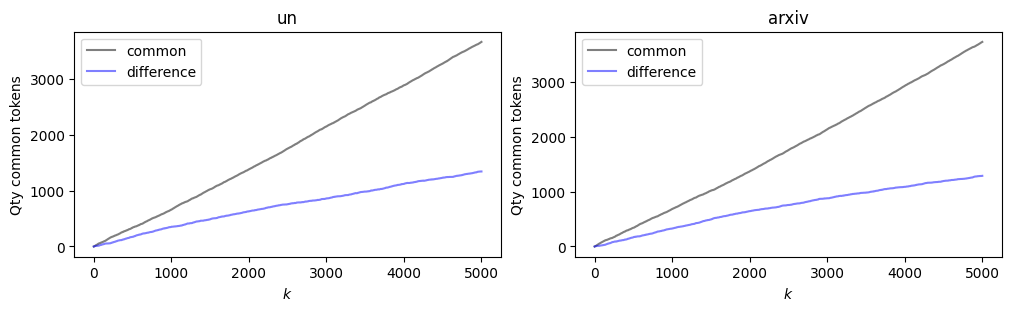

In [374]:
fig, axs = plt.subplots(1,2, figsize=(10,3), layout='constrained')
for idx, domain in enumerate(['un', 'arxiv']):
    axs[idx].plot(common_count[domain], color='k', alpha=.5, label='common')
    axs[idx].plot(greed_ex_count[domain], color="blue", alpha=.5, label='difference')
#     plt.plot(bpe_ex_count[domain], color="orange", alpha=.5, label='bpe')
    axs[idx].set_title(domain)
    axs[idx].legend()
    axs[idx].set_ylabel('Qty common tokens')
    axs[idx].set_xlabel('$k$')
plt.show()

In [21]:
test = pickle.load(open(f'python_outputs/hf_sp_bpe/un_tokens.pkl', "rb"))